In [11]:
%%capture
!pip install ipywidgets pyserial matplotlib 
%matplotlib widget
import serial,socket,os,glob
import matplotlib.pyplot as plt
#import atexit
import numpy as np
import time
from ipywidgets import interact, interact_manual,interactive,widgets,Layout


In [12]:
if socket.gethostname() == 'ASUS515':
    port = '/dev/ttyACM0'
elif     socket.gethostname() == 'juan-i7':
    port = '/dev/ttyUSB0'

In [13]:
#distancia de aplicacion fuerza (m)
L1 = (260+45)*1e-3
#brazo de la balanza (m)
L2 = 650e-3
masas = np.array([0,20,30,50,60,70,80])
lecturas = np.array([89.5,80.32,79.26,63.17,59.54,58.6,55.32])

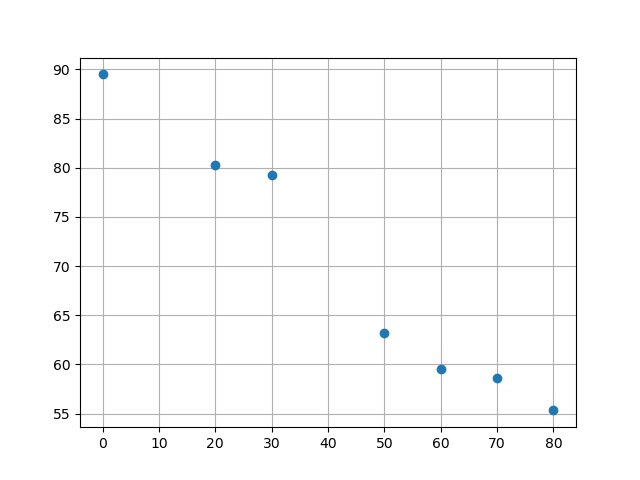

In [14]:
fig,ax = plt.subplots()
ax.plot(masas,lecturas,'o');
ax.grid()

In [27]:
def f_acquire(b=1):
    archivo = open('output.txt','w')
    fsampling = 25
    dt = 1/fsampling
    tventana = 8
    tiempo_total,valores = np.zeros((2,fsampling*tventana))
    valores[valores==0] = np.NaN
    arduino = serial.Serial(port, 115200, timeout=1/80)
    i = 0
    time0 = time.time()
    time1 = time.time()-time0
    linea = arduino.readline() 
    while i<fsampling*3:
        linea = arduino.readline()   # read a '\n' terminated line

        texto = str(linea.decode('ascii')).split('\r')[0]
        
        if texto!= '\n':
            if texto != '':
                data = float(texto)                
                if i ==0:
                    time0 = time.time()
                     
                time1 = time.time()-time0
                tiempo_total[i] = time1
                valores[i] = data
                i += 1
                line1.set_data([tiempo_total,valores])
                fig1.canvas.draw()
                archivo.write(f'{time1:.4f},{data:.2f}\n')
    arduino.close()
    archivo.close()
    return tiempo_total,valores

def f_save(b=1):
    nombre = f'B_{rigidez_i.value:03d}_L_{int(longitud_i.value*100):03d}.txt'
    if os.path.isfile(nombre):
        nombre = np.sort(glob.glob(nombre[:3]+'*'))[-1]
        partes = nombre.split('_')
        if len(partes)<5:
            numfile = 0
            nombre = nombre.replace(f'.txt',f'_{numfile:0d}.txt') 
        else:
            numfile = int(nombre.split('.txt')[0][-1:])
            nombre = nombre.replace(f'_{numfile:0d}.txt',f'_{numfile+1:0d}.txt')   
    print(nombre)
    os.rename('output.txt',nombre)
    
    
    

In [32]:
#t,w = f_acquire()
plt.ioff()
B_s = [1,30,80,180]
long_s = [0.75,1,1.25,1.5]

outputw = widgets.Output()
output_balanza = widgets.HBox(layout={'border': '4px solid black'})
masa = widgets.FloatText(    value=50,     description='Masa (g):',     disabled=False )





punto_i = widgets.FloatText(  value=0,     description='Punto nº',     disabled=False )

output = widgets.Output()
ylims = widgets.FloatRangeSlider(value=[-2, 2],
    min=-10,
    max=10.0,
    step=0.5,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f', layout = widgets.Layout(width='300px')
)
xlims_label = widgets.Label('Time:')
xlims = widgets.FloatRangeSlider(value=[0, 2],
    min=0,
    max=5.0,
    step=0.5,

    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='.2f', layout = widgets.Layout(width='200px',Positioning='bottom')
)

ylims_label = widgets.Label('Force:')

boton_inicio_captura = widgets.Button(description='Inicio')
boton_save = widgets.Button(description='Guardar')
plt.ioff()

parametros_flaps = widgets.VBox() 
plot_params = widgets.HBox()
plot_params.children = (widgets.VBox([xlims,xlims_label]),widgets.VBox([ylims,ylims_label]))

fig1, ax1 = plt.subplots(constrained_layout=True, figsize=(2, 2))
fig2, ax2 = plt.subplots(constrained_layout=True, figsize=(5, 3))
line1, = ax1.plot([], [], lw=2)
line2, = ax2.plot([], [], lw=2)
# move the toolbar to the bottom
fig1.canvas.toolbar_position = 'bottom'
fig2.canvas.toolbar_position = 'bottom'
ax1.grid(True)  
ax2.grid(True)  




box_layout = widgets.Layout()
boton_inicio_captura.on_click(f_acquire)
boton_save.on_click(f_save)
parametros_flaps.children = ([masa,punto_i])
panel_control = widgets.VBox(layout={'border': '1px solid black'})
panel_control.children = ([parametros_flaps,boton_inicio_captura,boton_save,fig1.canvas])
output_balanza.children = ([panel_control,fig2.canvas])


ax1.set_xlim([0,7])
ax1.set_ylim([-5,30]);

In [33]:
display(output_balanza)